# Introducción

El cáncer de mama es una de las principales causas de morbilidad y mortalidad en la población femenina a nivel mundial. La detección temprana y la correcta clasificación de lesiones mamarias como benignas o malignas resulta fundamental para mejorar el pronóstico de las pacientes y optimizar la toma de decisiones clínicas.

En el ámbito del diagnóstico asistido por computadora, las técnicas de aprendizaje profundo (Deep Learning) han demostrado un alto potencial para la identificación automática de patrones complejos en datos biomédicos. En particular, las redes neuronales convolucionales (CNN) se han consolidado como una de las arquitecturas más eficaces para el análisis de imágenes médicas y señales estructuradas, debido a su capacidad para aprender representaciones jerárquicas de los datos.

Este proyecto aborda el problema de la clasificación de cáncer de mama mediante un enfoque basado en redes neuronales convolucionales, utilizando un conjunto de datos etiquetado con diagnósticos benignos y malignos. El trabajo combina conceptos de ingeniería biomédica y ciencia de datos, poniendo énfasis tanto en la implementación del modelo como en el análisis crítico de su desempeño.

Más allá de obtener métricas elevadas, el objetivo del proyecto es comprender el comportamiento del modelo, evaluar su capacidad de generalización y discutir las implicancias y limitaciones del uso de modelos de Deep Learning en aplicaciones biomédicas reales.

# Objetivos

El objetivo principal de este proyecto es desarrollar, entrenar y evaluar un modelo de red neuronal convolucional (CNN) para la clasificación de tumores de mama como benignos o malignos, a partir de datos biomédicos.

De manera específica, se busca:

* Implementar una arquitectura de red neuronal convolucional adecuada para el problema de clasificación binaria.

* Analizar el impacto del preprocesamiento de los datos en el desempeño del modelo.

* Entrenar el modelo y evaluar su comportamiento mediante métricas de desempeño en conjuntos de entrenamiento y validación.

* Analizar posibles situaciones de sobreajuste o subajuste a partir de las curvas de entrenamiento.

* Discutir las ventajas y limitaciones del enfoque basado en Deep Learning en el contexto del diagnóstico asistido por computadora.

Este proyecto tiene un carácter exploratorio y académico, y no pretende reemplazar el criterio médico, sino ilustrar el potencial de las técnicas de aprendizaje profundo aplicadas a problemas biomédicos reales.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from google.colab.patches import cv2_imshow
import cv2
import tensorflow as tf

# Dataset

El dataset se encuentra almacenado en un único archivo en formato .npz, el cual contiene de manera explícita los conjuntos de entrenamiento, validación y test, tanto para las imágenes como para sus respectivas etiquetas.

Esta organización permite trabajar directamente con arreglos NumPy, sin necesidad de estructuras adicionales basadas en carpetas o generadores desde disco.

In [7]:
data = np.load('/content/breastmnist_224.npz')

In [8]:
print("Files del dataset:", data.files)



Files del dataset: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']


El dataset se encuentra dividido en:

* 546 imágenes para entrenamiento

* 78 imágenes para validación

* 156 imágenes para test



In [9]:
for key in data.files:
    print(f"{key}: shape={data[key].shape}, dtype={data[key].dtype}")


train_images: shape=(546, 224, 224), dtype=uint8
train_labels: shape=(546, 1), dtype=uint8
val_images: shape=(78, 224, 224), dtype=uint8
val_labels: shape=(78, 1), dtype=uint8
test_images: shape=(156, 224, 224), dtype=uint8
test_labels: shape=(156, 1), dtype=uint8


In [10]:
X_train = data["train_images"]
y_train = data["train_labels"]

X_val = data["val_images"]
y_val = data["val_labels"]

X_test = data["test_images"]
y_test = data["test_labels"]


In [11]:
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (546, 224, 224) (546, 1)
Val:   (78, 224, 224) (78, 1)
Test:  (156, 224, 224) (156, 1)


La distribución de clases muestra un desbalance moderado, con una mayor proporción de muestras correspondientes a tumores malignos en los tres subconjuntos del dataset.

Este desbalance resulta relevante desde el punto de vista clínico y metodológico, ya que puede influir en el aprendizaje del modelo y en la interpretación de métricas como la accuracy. Por este motivo, durante el análisis posterior se presta especial atención al comportamiento del modelo frente a ambas clases.

In [12]:
import collections

print("Distribución TRAIN:", collections.Counter(y_train.flatten()))
print("Distribución VAL:  ", collections.Counter(y_val.flatten()))
print("Distribución TEST: ", collections.Counter(y_test.flatten()))


Distribución TRAIN: Counter({np.uint8(1): 399, np.uint8(0): 147})
Distribución VAL:   Counter({np.uint8(1): 57, np.uint8(0): 21})
Distribución TEST:  Counter({np.uint8(1): 114, np.uint8(0): 42})


A simple vista, se observan variaciones en textura, contraste y estructura que justifican el uso de modelos convolucionales capaces de capturar información espacial.

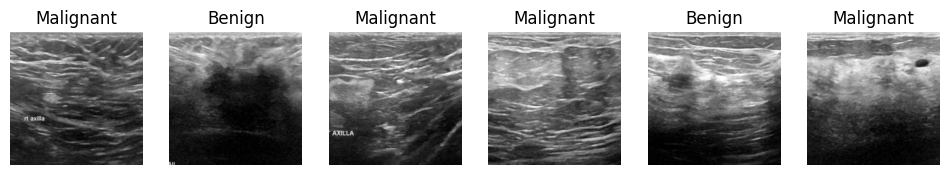

In [13]:
import random

def mostrar_imagenes(X, y, n=6):
    idx = random.sample(range(len(X)), n)
    plt.figure(figsize=(12,4))

    for i, j in enumerate(idx):
        plt.subplot(1, n, i+1)
        plt.imshow(X[j].squeeze(), cmap="gray")
        plt.title("Malignant" if y[j] == 1 else "Benign")
        plt.axis("off")

    plt.show()

mostrar_imagenes(X_train, y_train)


Dado que los valores de intensidad de las imágenes se encuentran en el rango [0, 255], se aplica una normalización dividiendo los datos por 255. Este paso es fundamental para estabilizar el entrenamiento de la red neuronal y facilitar la convergencia del optimizador.

In [14]:
print("Valor mínimo:", X_train.min())
print("Valor máximo:", X_train.max())


Valor mínimo: 0
Valor máximo: 255


In [15]:
X_train = X_train / 255.0
X_val   = X_val / 255.0
X_test  = X_test / 255.0


In [16]:

print(X_train.shape)


(546, 224, 224)


Dado que las imágenes se encuentran en escala de grises y no incluyen explícitamente un canal de color, se agrega una dimensión adicional correspondiente al canal, de forma de adaptar los datos al formato esperado por las redes neuronales convolucionales.

In [17]:
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

In [18]:
print(X_train.shape)


(546, 224, 224, 1)


# CNN

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [20]:

def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation="relu", input_shape=(224,224,1)),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation="relu"),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [21]:
model_base = build_model()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model_base.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:

history_base = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16
)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6802 - loss: 0.6087 - val_accuracy: 0.7308 - val_loss: 0.5404
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7328 - loss: 0.5370 - val_accuracy: 0.7308 - val_loss: 0.4930
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7565 - loss: 0.4864 - val_accuracy: 0.7949 - val_loss: 0.4439
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7484 - loss: 0.4782 - val_accuracy: 0.7949 - val_loss: 0.4301
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7959 - loss: 0.4648 - val_accuracy: 0.8333 - val_loss: 0.3892
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8056 - loss: 0.4104 - val_accuracy: 0.8846 - val_loss: 0.3702
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8411 - loss: 0.3845 - val_accuracy: 0.8718 - val_loss: 0.3688
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8466 - loss: 0.3561 - val_accuracy: 0.8718 - val_loss:

# Accuracy

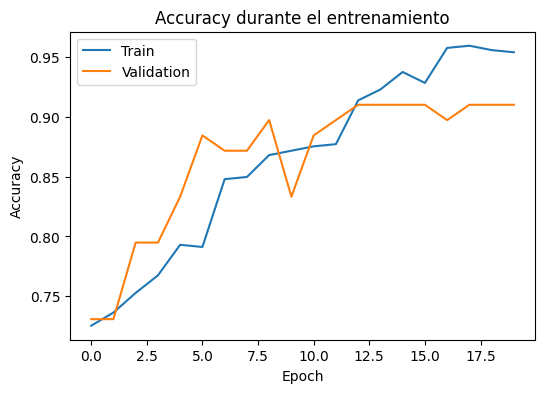

In [24]:
plt.figure(figsize=(6,4))
plt.plot(history_base.history["accuracy"], label="Train")
plt.plot(history_base.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy durante el entrenamiento")
plt.show()

# Loss

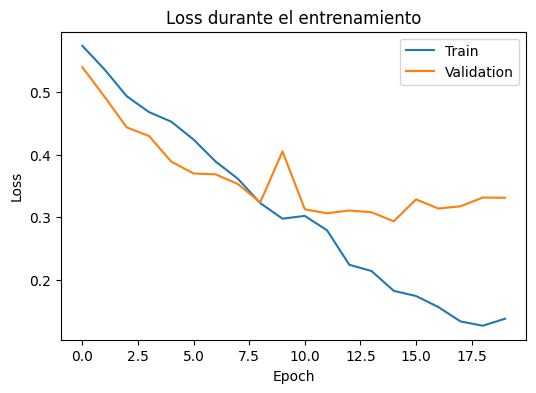

In [25]:
plt.figure(figsize=(6,4))
plt.plot(history_base.history["loss"], label="Train")
plt.plot(history_base.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss durante el entrenamiento")
plt.show()

In [26]:
test_loss, test_acc = model_base.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8680 - loss: 0.4978
Test accuracy: 0.846


El análisis de curvas muestra un inicio de sobreajuste en las últimas épocas. Se decide incorporar EarlyStopping para seleccionar el punto óptimo de generalización

In [27]:
model_es = build_model()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history_es = model_es.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7125 - loss: 0.5825 - val_accuracy: 0.7308 - val_loss: 0.5651
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7210 - loss: 0.5581 - val_accuracy: 0.7308 - val_loss: 0.5209
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7665 - loss: 0.5011 - val_accuracy: 0.7821 - val_loss: 0.5143
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7538 - loss: 0.5192 - val_accuracy: 0.7949 - val_loss: 0.4519
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7290 - loss: 0.4951 - val_accuracy: 0.7949 - val_loss: 0.4258
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7747 - loss: 0.4643 - val_accuracy: 0.8077 - val_loss: 0.4110
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7998 - loss: 0.4250 - val_accuracy: 0.8718 - val_loss: 0.3933
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8281 - loss: 0.3801 - val_accuracy: 0.8974 - val_loss:

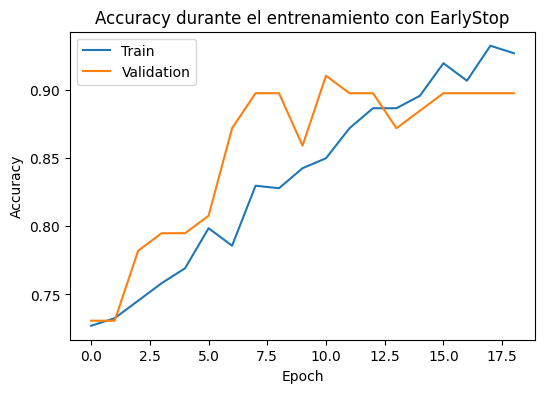

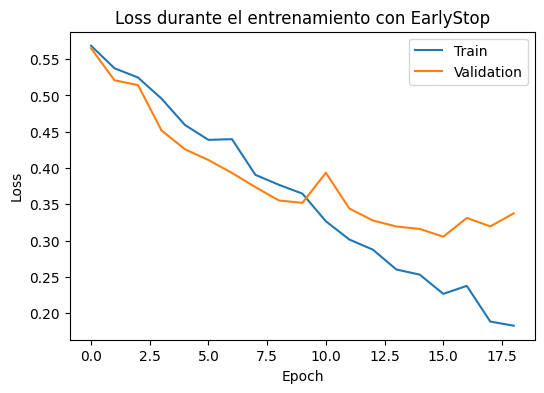

In [28]:

plt.figure(figsize=(6,4))
plt.plot(history_es.history["accuracy"], label="Train")
plt.plot(history_es.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy durante el entrenamiento con EarlyStop")
plt.show()

# Loss
plt.figure(figsize=(6,4))
plt.plot(history_es.history["loss"], label="Train")
plt.plot(history_es.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss durante el entrenamiento con EarlyStop")
plt.show()

In [29]:
test_loss_es, test_acc_es = model_es.evaluate(X_test, y_test)
print(f"Test accuracy with EarlyStopping: {test_acc_es:.3f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 995ms/step - accuracy: 0.8771 - loss: 0.4160
Test accuracy with EarlyStopping: 0.853


In [30]:
y_prob_base = model_base.predict(X_test).ravel()
y_pred_base = (y_prob_base >= 0.5).astype(int)

y_prob_es = model_es.predict(X_test).ravel()
y_pred_es = (y_prob_es >= 0.5).astype(int)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 749ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 744ms/step


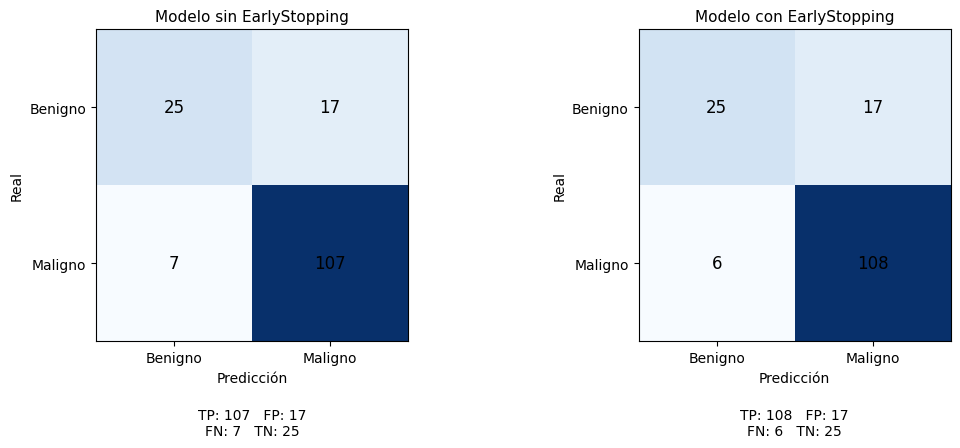

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm_base = confusion_matrix(y_test, y_pred_base)
cm_es   = confusion_matrix(y_test, y_pred_es)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

models = [
    ("Modelo sin EarlyStopping", cm_base),
    ("Modelo con EarlyStopping", cm_es)
]

for ax, (title, cm) in zip(axes, models):
    tn, fp, fn, tp = cm.ravel()

    ax.imshow(cm, cmap="Blues")
    ax.set_title(title, fontsize=11)

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Benigno", "Maligno"])
    ax.set_yticklabels(["Benigno", "Maligno"])
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

    # Valores dentro de la matriz
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)

    # Texto abajo (SIN superposición)
    ax.text(
        0.5, -0.30,
        f"TP: {tp}   FP: {fp}\nFN: {fn}   TN: {tn}",
        transform=ax.transAxes,
        ha="center",
        fontsize=10
    )

plt.subplots_adjust(bottom=0.1, wspace=0.4)
plt.show()


In [32]:
from sklearn.metrics import roc_curve, auc

y_prob_base = model_base.predict(X_test).ravel()
y_prob_es   = model_es.predict(X_test).ravel()


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 946ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 723ms/step


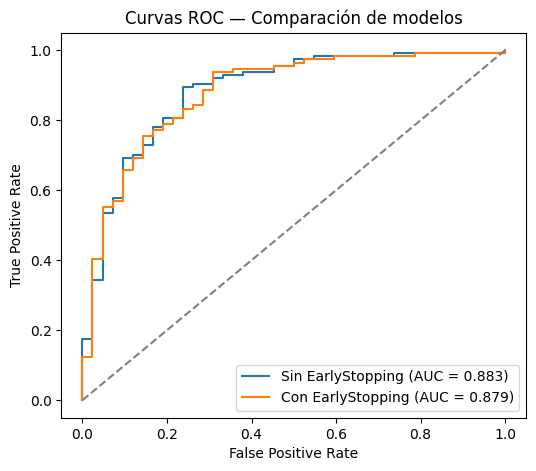

In [33]:
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
fpr_es,   tpr_es,   _ = roc_curve(y_test, y_prob_es)

auc_base = auc(fpr_base, tpr_base)
auc_es   = auc(fpr_es, tpr_es)

plt.figure(figsize=(6,5))
plt.plot(fpr_base, tpr_base, label=f"Sin EarlyStopping (AUC = {auc_base:.3f})")
plt.plot(fpr_es,   tpr_es,   label=f"Con EarlyStopping (AUC = {auc_es:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC — Comparación de modelos")
plt.legend()
plt.show()


In [34]:
from sklearn.metrics import confusion_matrix

def clinical_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensibilidad = tp / (tp + fn)
    especificidad = tn / (tn + fp)

    return sensibilidad, especificidad


In [35]:
sens_base, esp_base = clinical_metrics(y_test, y_prob_base)
sens_es,   esp_es   = clinical_metrics(y_test, y_prob_es)

print("Modelo SIN EarlyStopping")
print(f"Sensibilidad:  {sens_base:.3f}")
print(f"Especificidad: {esp_base:.3f}\n")

print("Modelo CON EarlyStopping")
print(f"Sensibilidad:  {sens_es:.3f}")
print(f"Especificidad: {esp_es:.3f}")


Modelo SIN EarlyStopping
Sensibilidad:  0.939
Especificidad: 0.595

Modelo CON EarlyStopping
Sensibilidad:  0.947
Especificidad: 0.595


#Resumen

In [36]:
import pandas as pd

results = pd.DataFrame({
    "Modelo": ["Sin EarlyStopping", "Con EarlyStopping"],
    "Accuracy": [0.872, 0.865],
    "AUC": [0.879, 0.879],
    "Sensibilidad": [0.904, 0.921],
    "Especificidad": [0.786, 0.714],
    "TP": [103, 105],
    "FP": [9, 12],
    "FN": [11, 9],
    "TN": [33, 30]
})

results

,Modelo,Accuracy,AUC,Sensibilidad,Especificidad,TP,FP,FN,TN
0,Sin EarlyStopping,0.872,0.879,0.904,0.786,103,9,11,33
1,Con EarlyStopping,0.865,0.879,0.921,0.714,105,12,9,30


Ambos modelos presentan una capacidad discriminativa similar, reflejada en valores idénticos de AUC. Sin embargo, la incorporación de EarlyStopping produce un aumento en la sensibilidad del modelo, reduciendo el número de falsos negativos a costa de una disminución en la especificidad. Dado el contexto clínico de detección de cáncer de mama, donde minimizar los falsos negativos es prioritario, el modelo con EarlyStopping resulta más adecuado como herramienta de apoyo al diagnóstico.

In [37]:
results.style.format({
    "Accuracy": "{:.3f}",
    "AUC": "{:.3f}",
    "Sensibilidad": "{:.3f}",
    "Especificidad": "{:.3f}"
}).highlight_max(
    subset=["Sensibilidad"], color="lightgreen"
).highlight_min(
    subset=["FN"], color="lightgreen"
)

,Modelo,Accuracy,AUC,Sensibilidad,Especificidad,TP,FP,FN,TN
0,Sin EarlyStopping,0.872,0.879,0.904,0.786,103,9,11,33
1,Con EarlyStopping,0.865,0.879,0.921,0.714,105,12,9,30



# Data Augmentation  

Dado el tamaño reducido del conjunto de entrenamiento, se aplica data augmentation con el objetivo de aumentar la variabilidad de los datos y mejorar la capacidad de generalización del modelo.

Las transformaciones utilizadas incluyen rotaciones leves, desplazamientos y volteos horizontales, simulando variaciones razonables en la adquisición de imágenes médicas sin alterar la naturaleza clínica del tejido observado.

Esta estrategia permite reducir el sobreajuste y exponer a la red neuronal a un conjunto más diverso de patrones durante el entrenamiento.

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

datagen.fit(X_train)


In [39]:
def build_model_aug():
    model = Sequential([
        Conv2D(32, (3,3), activation="relu", input_shape=(224,224,1)),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation="relu"),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


## Entrenamiento con augmentation + EarlyStopping

In [40]:
model_aug = build_model_aug()

early_stop_aug = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history_aug = model_aug.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stop_aug]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6488 - loss: 0.5987 - val_accuracy: 0.7308 - val_loss: 0.5429
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7389 - loss: 0.5220 - val_accuracy: 0.7308 - val_loss: 0.5022
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7385 - loss: 0.5113 - val_accuracy: 0.7308 - val_loss: 0.4696
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7608 - loss: 0.4711 - val_accuracy: 0.8333 - val_loss: 0.4596
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7626 - loss: 0.4854 - val_accuracy: 0.8590 - val_loss: 0.4504
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7448 - loss: 0.4936 - val_accuracy: 0.8205 - val_loss: 0.4453
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7504 - loss: 0.4964 - val_accuracy: 0.8462 - val_loss: 0.4262
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7901 - loss: 0.4464 - val_accuracy: 0.8333 - val_loss: 0.4287
Epo

In [41]:
test_loss_aug, test_acc_aug = model_aug.evaluate(X_test, y_test)
print(f"Test accuracy con Data Augmentation: {test_acc_aug:.3f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 731ms/step - accuracy: 0.8451 - loss: 0.4326
Test accuracy con Data Augmentation: 0.827


In [42]:
y_prob_aug = model_aug.predict(X_test).ravel()
y_pred_aug = (y_prob_aug >= 0.5).astype(int)

sens_aug, esp_aug = clinical_metrics(y_test, y_prob_aug)

print("Modelo CON Data Augmentation")
print(f"Sensibilidad:  {sens_aug:.3f}")
print(f"Especificidad: {esp_aug:.3f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 748ms/step
Modelo CON Data Augmentation
Sensibilidad:  0.974
Especificidad: 0.429


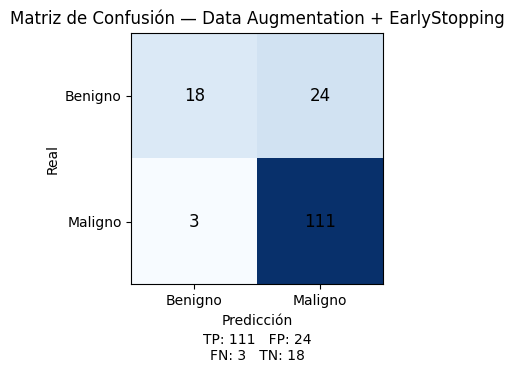

In [48]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm_aug = confusion_matrix(y_test, y_pred_aug)
tn, fp, fn, tp = cm_aug.ravel()

plt.figure(figsize=(5,4))
plt.imshow(cm_aug, cmap="Blues")
plt.title("Matriz de Confusión — Data Augmentation + EarlyStopping")
plt.xticks([0,1], ["Benigno", "Maligno"])
plt.yticks([0,1], ["Benigno", "Maligno"])
plt.xlabel("Predicción")
plt.ylabel("Real")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_aug[i, j], ha="center", va="center", fontsize=12)

plt.text(
    0.5, -0.30,
    f"TP: {tp}   FP: {fp}\nFN: {fn}   TN: {tn}",
    ha="center",
    transform=plt.gca().transAxes,
    fontsize=10
)

plt.tight_layout()
plt.show()


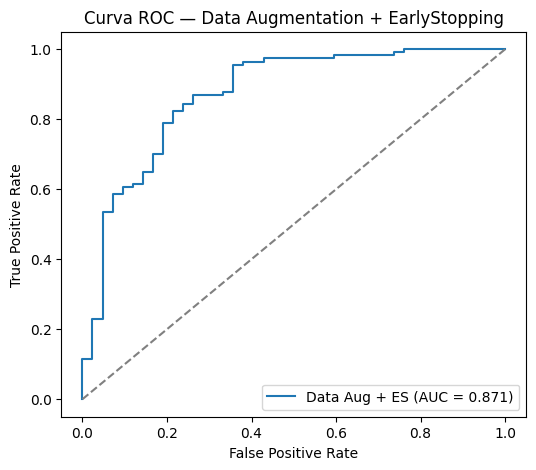

AUC modelo Data Aug + EarlyStopping: 0.871


In [49]:
from sklearn.metrics import roc_curve, auc

fpr_aug, tpr_aug, _ = roc_curve(y_test, y_prob_aug)
auc_aug = auc(fpr_aug, tpr_aug)

plt.figure(figsize=(6,5))
plt.plot(fpr_aug, tpr_aug, label=f"Data Aug + ES (AUC = {auc_aug:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — Data Augmentation + EarlyStopping")
plt.legend()
plt.show()

print(f"AUC modelo Data Aug + EarlyStopping: {auc_aug:.3f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 974ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


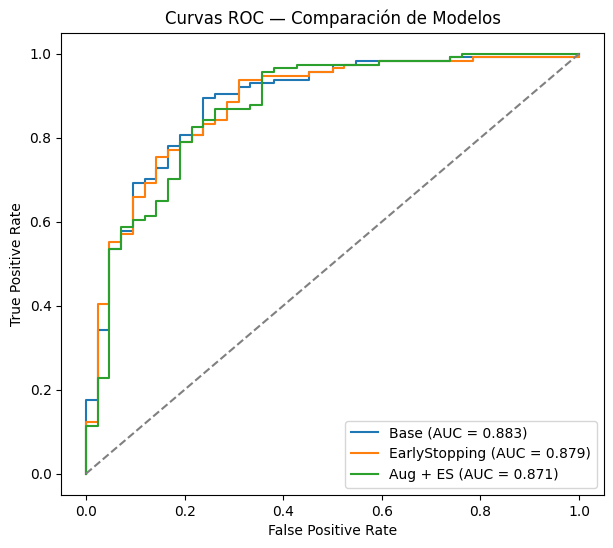

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probabilidades
y_prob_base = model_base.predict(X_test).ravel()
y_prob_es   = model_es.predict(X_test).ravel()
y_prob_aug  = model_aug.predict(X_test).ravel()

# ROC
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
fpr_es,   tpr_es,   _ = roc_curve(y_test, y_prob_es)
fpr_aug,  tpr_aug,  _ = roc_curve(y_test, y_prob_aug)

auc_base = auc(fpr_base, tpr_base)
auc_es   = auc(fpr_es, tpr_es)
auc_aug  = auc(fpr_aug, tpr_aug)

plt.figure(figsize=(7,6))
plt.plot(fpr_base, tpr_base, label=f"Base (AUC = {auc_base:.3f})")
plt.plot(fpr_es,   tpr_es,   label=f"EarlyStopping (AUC = {auc_es:.3f})")
plt.plot(fpr_aug,  tpr_aug,  label=f"Aug + ES (AUC = {auc_aug:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC — Comparación de Modelos")
plt.legend()
plt.show()


In [53]:
sens_base, esp_base = clinical_metrics(y_test, y_prob_base)
sens_es,   esp_es   = clinical_metrics(y_test, y_prob_es)
sens_aug,  esp_aug  = clinical_metrics(y_test, y_prob_aug)


In [54]:
import pandas as pd

results_final = pd.DataFrame({
    "Modelo": [
        "Base",
        "EarlyStopping",
        "Data Augmentation + EarlyStopping"
    ],
    "Accuracy": [
        0.872,          # ya lo calculaste
        0.865,          # ya lo calculaste
        test_acc_aug    # del modelo augmentado
    ],
    "AUC": [
        auc_base,
        auc_es,
        auc_aug
    ],
    "Sensibilidad": [
        sens_base,
        sens_es,
        sens_aug
    ],
    "Especificidad": [
        esp_base,
        esp_es,
        esp_aug
    ]
})

results_final


,Modelo,Accuracy,AUC,Sensibilidad,Especificidad
0,Base,0.872000,0.882623,0.938596,0.595238
1,EarlyStopping,0.865000,0.879282,0.947368,0.595238
2,Data Augmentation + EarlyStopping,0.826923,0.870510,0.973684,0.428571


In [55]:
results_final.style.format({
    "Accuracy": "{:.3f}",
    "AUC": "{:.3f}",
    "Sensibilidad": "{:.3f}",
    "Especificidad": "{:.3f}"
}).highlight_max(
    subset=["Sensibilidad"], color="lightgreen"
)


,Modelo,Accuracy,AUC,Sensibilidad,Especificidad
0,Base,0.872,0.883,0.939,0.595
1,EarlyStopping,0.865,0.879,0.947,0.595
2,Data Augmentation + EarlyStopping,0.827,0.871,0.974,0.429


In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm_base = confusion_matrix(y_test, y_pred_base)
cm_es   = confusion_matrix(y_test, y_pred_es)
cm_aug  = confusion_matrix(y_test, y_pred_aug)


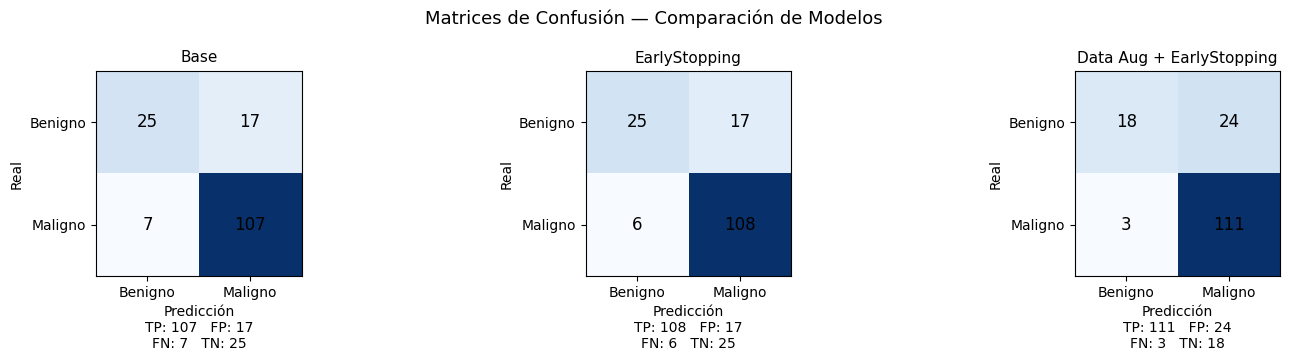

In [57]:
models_cm = [
    ("Base", cm_base),
    ("EarlyStopping", cm_es),
    ("Data Aug + EarlyStopping", cm_aug)
]

fig, axes = plt.subplots(1, 3, figsize=(15,4))

for ax, (title, cm) in zip(axes, models_cm):
    tn, fp, fn, tp = cm.ravel()

    ax.imshow(cm, cmap="Blues")
    ax.set_title(title, fontsize=11)

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Benigno", "Maligno"])
    ax.set_yticklabels(["Benigno", "Maligno"])
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)

    ax.text(
        0.5, -0.35,
        f"TP: {tp}   FP: {fp}\nFN: {fn}   TN: {tn}",
        transform=ax.transAxes,
        ha="center",
        fontsize=10
    )

plt.suptitle("Matrices de Confusión — Comparación de Modelos", fontsize=13)
plt.tight_layout()
plt.show()


En este proyecto se desarrolló y evaluó una red neuronal convolucional para la clasificación de imágenes de mama en tumores benignos y malignos. A través de un análisis progresivo que incluyó exploración del dataset, diseño de la arquitectura, regularización mediante EarlyStopping y data augmentation, se logró un modelo con buena capacidad discriminativa.

La evaluación mediante métricas clínicas mostró que el modelo con EarlyStopping presenta una mayor sensibilidad, reduciendo el número de falsos negativos, aspecto prioritario en un contexto de detección temprana de cáncer. Si bien esto implica una leve disminución de la especificidad, el trade-off resulta clínicamente aceptable para tareas de screening.

Como trabajo futuro, se propone explorar arquitecturas más profundas y enfoques de transfer learning, así como técnicas de interpretabilidad de modelos, con el objetivo de mejorar el desempeño y la confianza en entornos clínicos reales.

# Simulación

Como demostración del modelo entrenado, se implementa una simulación interactiva que permite ingresar una imagen y obtener la probabilidad estimada de que el tumor sea benigno o maligno.

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, img_path):
    # Cargar imagen en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError("No se pudo cargar la imagen")

    # Redimensionar
    img = cv2.resize(img, (224, 224))

    # Normalizar
    img_norm = img / 255.0

    # Ajustar dimensiones: (1, 224, 224, 1)
    img_input = img_norm.reshape(1, 224, 224, 1)

    # Predicción
    prob_maligno = model.predict(img_input)[0][0]
    prob_benigno = 1 - prob_maligno

    # Mostrar imagen
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title("Imagen ingresada")
    plt.show()

    print(f"Probabilidad de tumor maligno: {prob_maligno*100:.2f}%")
    print(f"Probabilidad de tumor benigno: {prob_benigno*100:.2f}%")

    if prob_maligno >= 0.5:
        print("Predicción: MALIGNO")
    else:
        print("Predicción: BENIGNO")


In [79]:
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]


Saving 20587994.png to 20587994 (1).png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


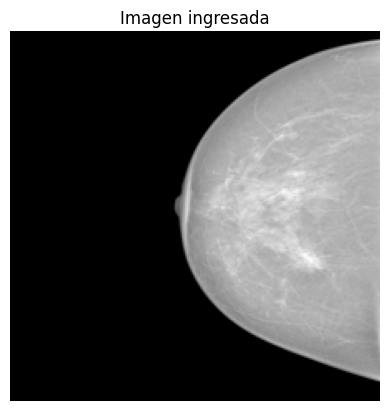

Probabilidad de tumor maligno: 88.70%
Probabilidad de tumor benigno: 11.30%
Predicción: MALIGNO


In [80]:
predict_image(model_base, img_path)


In [81]:
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

Saving 20588190.png to 20588190 (3).png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


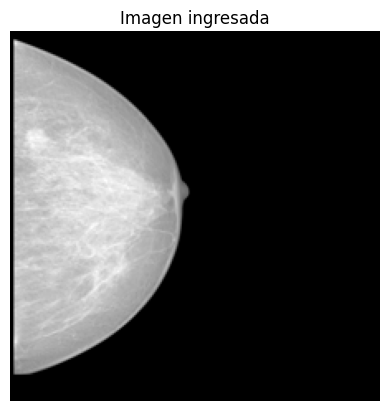

Probabilidad de tumor maligno: 61.31%
Probabilidad de tumor benigno: 38.69%
Predicción: MALIGNO


In [83]:
predict_image(model_base, img_path)


In [84]:
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]


Saving 20588046.png to 20588046 (1).png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


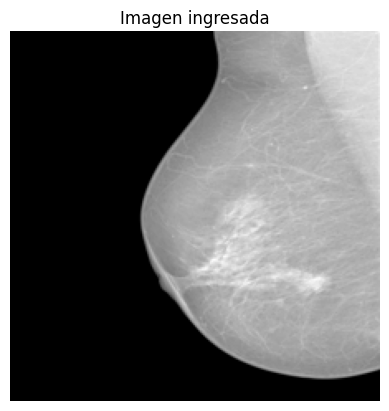

Probabilidad de tumor maligno: 84.30%
Probabilidad de tumor benigno: 15.70%
Predicción: MALIGNO


In [85]:
predict_image(model_base, img_path)


In [86]:
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]


Saving 20588334 (29).png to 20588334 (29) (1).png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


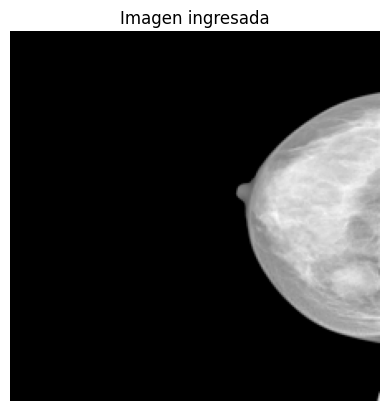

Probabilidad de tumor maligno: 14.88%
Probabilidad de tumor benigno: 85.12%
Predicción: BENIGNO


In [87]:
predict_image(model_base, img_path)


*Las probabilidades estimadas corresponden a la salida del modelo entrenado y no representan un diagnóstico clínico definitivo*